# Neural Network From Scratch

<img style="float: left; padding-right:0.5em;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/320px-MnistExamples.png">

This notebook trains a simple artificial neural network from end-to-end with numpy.

We will train a model to classify handwritten digits [0-9] using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). This is the "Hello World!" example for neural network based Computer Vision (CV) models.

# Data

Download `train.csv` from [this kaggle competition](https://www.kaggle.com/competitions/digit-recognizer/data), and set the `TRAIN_DATA_PATH` variable below.

In [23]:
TRAIN_DATA_PATH = "/your-path/train.csv"

import numpy as np
import pandas as pd

train_df = pd.read_csv(TRAIN_DATA_PATH)
data = np.array(train_df)

Each image captures a handwritten digit and has a resolution of `28 X 28` pixels, for a total of 784 pixels per image. Each pixel has a single value associated with it from [0, 255], which indicates its darkness.

`train.csv` represents each image as a single row in an `M x 785` matrix, where M is the number of images, and the number of columns consists of a) the number of pixels (784) per image and b) the label that denotes what the digit actually is.

- matrix[0] = [ label, pixel0, pixel1, pixel2, pixel3 ]
- image = matrix[0][1:] = [ pixel0, pixel1, pixel2, pixel3]
- label = matrix[0][0]

For example, let's look at a 2x2 image to understand how to "Unflatten" the 1D vector to the 2D matrix:

<img src="https://assets.leetcode.com/uploads/2021/08/26/image-20210826114243-1.png" alt="1D to 2D" width="436" height="151">


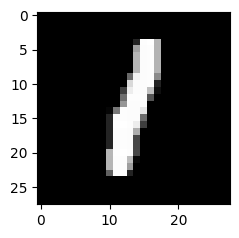

In [24]:
from matplotlib import pyplot as plt
import random


def show_image(flattened: np.array, m=28, n=28):
    assert flattened.ndim == 1, "input must be one dimensional"
    matrix = flattened.reshape(m, n)
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(matrix, interpolation="nearest")
    plt.gray()
    plt.show()


show_image(data[random.randint(0, len(data))][1:])

# Machine Learned Features vs Handcrafted Features

Let's brainstorm approaches to build a digit classifier w/out fancy ML. 

For example, we can break an input into distincitve `features` such as number of lines and loops([circle hough transform](https://en.wikipedia.org/wiki/Circle_Hough_Transform)). The digit '0' yields one loop loop, while the digit '8' yields two loops. The digits '9' and '6' both yield one loop and one line. Next, we can consider the spatial relation between these lines and loops. If the loop is on the bottom, it's a '6'.

Essentially, we just hand crafted "features", and composed rules to judge the final result based on the feature values . The quality of our algorithm is directely porportional to how well crafted each feature is.

In the above example, we hand crafted features, and as a result, could easily understand them. Alternatively, we can employ an artificial neural network to self learn all of the important features. While these features may not be interperable by humans, they certainly are distictive to the neural network. Let's further explore a neural network below.

# Multilayer Perceptron (MLP)

<img style="padding-right:0.5em;" src="https://res.cloudinary.com/practicaldev/image/fetch/s--2UPg0Z-6--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://imgur.com/KeIJEYy.jpeg">

The neural network architecture we will explore is the multi-layer perceptron (MLP), depicted above. Each node represents a neuron. Each column is an arrangement of neurons represent a layer.

The layer on the far left is dubbed the "input layer". The layer on the far right is the "output layer". The layers in between are the "hidden layers".

Each neuron in the input layer represents a pixel of the image, hence, there should by 784 inputs. The output layer should have 10 neurons, that correspond to a digit between [0, 9]. The number of hidden layers can be from [1, inf). We tune the number of hidden layers, and number of neurons per hidden layer empirically through experimentation.

### A fictional thought excercise on neurons "firing"

Imagine a human brain where certain neurons "light up" or "activate" based on observed inputs. E.g., some grouping of neurons light up when you smell pizza. In the above image, seeing a '9' lights up a certain pattern of neurons in the first hidden layer. The 2nd hidden layer lights up in response to the input pattern it observes in the first hidden layer. The output layer responds to how the neurons in the 2nd hidden layer are "activated".

The next few sentences are FICTIONAL, but hope to help provide an analagy to better understand what the neural network is doing. Rembemer the analagy above, where to detect a '9' we can see if there is a loop co-joined with a line? We can imagine (again, FICTIONAL) that the first layer of this network is finds the loops and lines. If the neurons in that layer light up in a certain way, that means we detected a some number of loops and or lines. The next layer interprets this, and is responsible for seeing how close the components are together. If the loop is near the top, and there is a vertical line immediately to the right of the loop, the output neurons light up a certain way, and in this case, ONLY the output node that corresponds to the '9' lights up.

Again, this isn't what is actually happening. The machine learns its own features that may not be human understandable. What's important to note is that the neurons in the preceding layer influence the neurons in the next layer. The first hidden layer recognizes patterns in the input. The 2nd hidden layer recognizes patterns in the 1st hidden layer. The output recognizes patterns in the 2nd hidden layer.

We will implement this structure to see how well it performs. But first, let's understand the basic constituent units.

### Artificial Neurons

<img src="https://www.researchgate.net/publication/338190342/figure/fig2/AS:840701659074561@1577450303999/Structures-of-artificial-neural-network-ANN-model-that-show-a-data-flows-in-the-ANN.png">

An artificial neuron is the base unit that makes up most (if not all) neural network based algorithms.

In the MLP, Each neuron consists of two components a) a linear combination of weighted inputs that feed into b) an activation function that outputs a value between 0 and 1.

Let's take a look below at the "perceptron", invented by Frank Rosenblatt in 1957. The perceptron uses the "threshold" activation function. If the weighted sum of inputs exceeds a given threshold, the neuron "activates".

<img src ="https://miro.medium.com/v2/resize:fit:720/format:webp/1*FBJqWE6AHt8HMZ7XHW9uWg.png">
<!-- <img src="https://www.researchgate.net/publication/281953313/figure/fig1/AS:668914816139278@1536493128709/Architecture-of-the-three-layer-multilayer-perceptron-MLP-neural-network_Q640.jpg"> -->

### Sigmoid Neuron - a smoothed perceptron

The threshold function does not provide granular feedback. Small changes in inputs either result in no changes, or a binary 0->1 change. This property complicates functions that find optimal values of the weights (more on this later). We can solve this by using the sigmoid activation function instead. We can conceptualize it as a smoothed threshold function.

Text(0, 0.5, 'Sigmoid(X)')

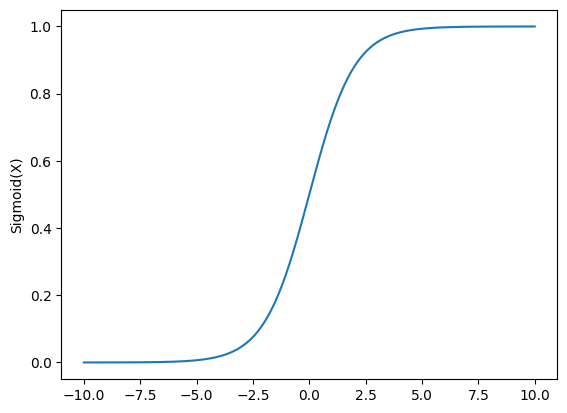

In [25]:
x = np.linspace(-10, 10, 1000)
sigmoid = 1 / (1 + np.exp(-x))
plt.plot(x, sigmoid, linestyle="solid")
plt.ylabel("Sigmoid(X)")

Note the similarity between the sigmoiod and threshold functions. At extreme inputs, they behave similiarly. In the above graph, values around (-2.5, 2.5) behave differenly from the threshold function. Now the output can be any value between 0 and 1, and small changes in the weights and biases can lead to small changes in the output.

The MLP actually uses sigmoid neurons, as opposed to perceptrons like its namesake. We will use the sigmoid in our implementation. 

### Softmax
We will use the sigmoid activation function on all hidden layers. However, on the last layer, we will use a **softmax** activation function.

![softmax equation](https://www.gstatic.com/education/formulas2/472522532/en/softmax_function.svg)

A softmax function normalizes the input into a probability distribution of K classes. In otherwords, in our last layer, we don't want postive or negative values.

We want to know the probability the input is an '0', '1', '2', '3'... or a '9'. These probabilities should sum to one.

# Let's Implement!

We are going to create the simplest MLP possible => input layer to one hidden layer => output layer.

We will visualize each neuron as having two components: a) the weighted sum, and b) the activation function. However, in the implementaion, we will separate these steps.

So visually, the neural network will look something like below:


In [26]:
%%capture install_logs
%pip install graphviz

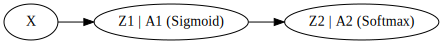

In [27]:
from graphviz import Digraph

nn_vis = Digraph()
nn_vis.graph_attr["rankdir"] = "LR"
nn_vis.node("X", "X")
nn_vis.node("1", "Z1 | A1 (Sigmoid)")
nn_vis.node("2", "Z2 | A2 (Softmax)")

nn_vis.edges(["X1", "12"])
nn_vis

But programatically, the pipeline looks more like below:

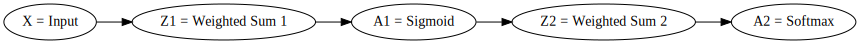

In [28]:
nn_impl_vis = Digraph()
nn_impl_vis.graph_attr["rankdir"] = "LR"
nn_impl_vis.node("X", "X = Input")
nn_impl_vis.node("1", "Z1 = Weighted Sum 1")
nn_impl_vis.node("2", "A1 = Sigmoid")
nn_impl_vis.node("3", "Z2 = Weighted Sum 2")
nn_impl_vis.node("4", "A2 = Softmax")

nn_impl_vis.edges(["X1", "12", "23", "34"])
nn_impl_vis

### X = Input Layer

784 neurons, one for each pixel in any given input image

Shape: (784, n)

### Z1 = Hidden Layer 1 -> Weighted Sum

$ Z1 = W1 * X + b1 $

For now, we will randomly set values for W1 and B1. The size of this layer is 10.

Shape:

- W1: (10, 784)
- b1: (10, 1)

### A1 = Hiddel Layer 1 -> Activation Function

$ A1 = Sigmoid(Z1) $

Remember each neuron consists of both weighted sum and activation function. So we should think of A1 and Z1 as one group.

Shape: (10, n)

### Z2 = Output Layer -> Weighted Sum

$ Z2 = W2 * A1 + b2 $

10 layers, one for each digit [0,9]

Shape: (10, n)

### A2 = Output Layer -> Activation Function

We use the softmax function (instead of the same activation function as A1) in order to ensure the final output is a probability that the input is one of the given options.

$ A2 = softmax(Z2) $

The output should look something like this:

```
predicted:  {
    "0": 0.002285052335889073,
    "1": 0.0021112562178389332,
    ...
    "8": 0.12941646239061635,
    "9": 0.5603362502515766
}
```

Shape: (10, n)

### Commonly used conventions -> Y_hat

The 'Ŷ' is often used in the literature to denote the prediction.

$ A2 = Y_{hat} $

### Human readable output

We will use the symbol $ Y\_{hum} $. This is not a common convention.

$ Y_{hum} = argmax(Y_{hat}) $

### End to End

$
Y_{hat} = A2 \\
Y_{hat} = softmax(Z2) \\
Y_{hat} = softmax(W2 * A1 + b2) \\
Y_{hat} = softmax(W2 * Sigmoid(Z1) + b2) \\
Y_{hat} = softmax(W2 * Sigmoid(W1 * X + b1) + b2)
$


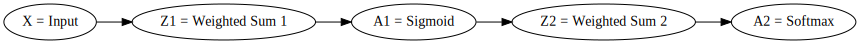

In [29]:
nn_impl_vis

### Step 1. Preprocess Data
1. Split `train.csv` into the training dataset, and the validation dataset. We will fit a model to the training data and measure 
performance on the validation data.

2. Normailze values to be between [0,1)

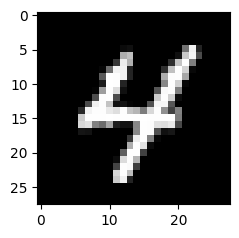

In [30]:
np.random.shuffle(data)
m, n = data.shape
num_examples, num_pixels = m, n - 1

validation_data_size = 10000
validation_data = data[0:validation_data_size].T
train_data = data[validation_data_size:].T


def get_x_y(matrix):
    def normalize(input):
        return input / 255.0

    X = normalize(matrix[1:])
    Y = matrix[0]

    return X, Y


X_val, Y_val = get_x_y(validation_data)
X_train, Y_train = get_x_y(train_data)

show_image(X_train.T[random.randint(0, len(X_train))])

### Step 2. Initialize Weights and Biases


In [31]:
def init_params():
    """
    rand returns values between [0, 1). Subtract 0.5 to ensure symmetrical range from [-0.5, 0.5)
    """
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2


W1, b1, W2, b2 = init_params()

### Step 3. Define Activation Functions

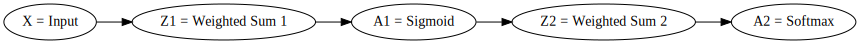

In [32]:
nn_impl_vis

In [33]:
def sigmoid(input):
    return 1 / (1 + np.exp(-input))


def softmax(input):
    return np.exp(input) / np.exp(input).sum(axis=0, keepdims=True)


def get_human_readable_prediction(Y_hat):
    return np.argmax(Y_hat, 0)

### Step 4. Forward propagation

In [34]:
def forward(X, W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1
    A1 = sigmoid(Z1)
    Z2 = W2.dot(A1) + b2
    Y_hat = softmax(Z2)
    return Z1, A1, Z2, Y_hat


Z1, A1, Z2, Y_hat = forward(X_train, W1, b1, W2, b2)
Y_hum = get_human_readable_prediction(Y_hat)

### Step 5. Audit Results

What do you think our accuracy is given we randomally initialized the weights and biases?

Let's first look at the predicted result, and the actual result. Note that we will express the actual result in a "one-hot" encoded format.

In one-hot encodings, only one position is "hot", while all others are zero.

predicted:  {
    "0": 0.05905948783152979,
    "1": 0.06274394722871603,
    "2": 0.1430820575032908,
    "3": 0.16667098372824396,
    "4": 0.0785915999896603,
    "5": 0.0565904123259883,
    "6": 0.3071298263639981,
    "7": 0.06920830156606073,
    "8": 0.015179435852722084,
    "9": 0.04174394760978998
}
actual:  {
    "0": 0.0,
    "1": 0.0,
    "2": 0.0,
    "3": 0.0,
    "4": 1.0,
    "5": 0.0,
    "6": 0.0,
    "7": 0.0,
    "8": 0.0,
    "9": 0.0
}


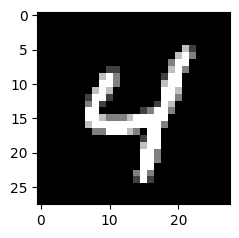

In [35]:
import json

digit_to_prob = dict([(i, p) for i, p in enumerate(list(Y_hat.T[0]))])
print("predicted: ", json.dumps(digit_to_prob, indent=4))

answer = dict([(i, 0.0) for i in range(0, 10)])
answer[Y_train[0]] = 1.0
print("actual: ", json.dumps(answer, indent=4))
show_image(X_train.T[0])

In [36]:
def get_accuracy(Y_hat_hum, Y_truth_hum):
    assert len(Y_hat_hum) == len(Y_truth_hum)
    return np.sum(Y_hat_hum == Y_truth_hum) / Y_truth_hum.size


print("Accuracy: ", get_accuracy(Y_hum, Y_train))
print("Predicted: ", Y_hum)
print("Actual: ", Y_train)

Accuracy:  0.09434375
Predicted:  [6 6 6 ... 6 6 6]
Actual:  [4 0 5 ... 8 5 9]


# Great Success!

We just successfully implemented an MLP! Its performance is literally random, but that's okay! The structure is 100% reminiscent of a model you would deploy in prodcution for inference!

### Conceptual Checkpoint

1. If our co-worker from a different team wants us to share our model so that they can use it on their own dataset, at the bare minimum, what do we need to share?

2. What parts of the MLP are highly reusable? And what parts are very application specific?

3. What are alternative ways to set the weights to do better than random?


# Going back to tune the weights and biases

Brief aside to an analagy. Imagine you are trying to find the perfect water temperature for a shower.

![shower lever](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT7fVauofLAnNZ2cPFCGkhQkoXufZJm7oQ_MIcqwXOKhLQqEo46V3LKpJH7h-VPHVIweZI&usqp=CAU)

1. You start by moving the knob to some position you think will work
2. You turn on the water
3. You test the result by feeling the water with your hand
4. You update the lever based on what you felt.

   a. If the water was WAY too cold, you know to make a large adjustment

   b. If the water was a little too cold, you make a small adjustment

   c. vice versa for when the water is too hot

5. Repeat steps 2-4 until you converge to the perfect water temperature

We can think of weights and biases as the shower lever. Let's pretend we have a mechanism that informs us on how much we need to adjust the weights and biases by based on how far off the predictions are from the truth. In this case, our process would be similar to the above shower example. We start with randomly initialized weights. Predict. Measure how bad the accuracy is. Go back and change the weights and biases. Predict. Measure again.

This process actually exists! We can use Gradient Descent to find the optimal values for the weights and biases.

### Gradient Descent; An Overview
Gradient descent, in the context of an artificial network, conists of a few key components:

1. Cost function
2. Backpropagation to calculate the optimal "direction" to step in to minimize the cost.
3. Take a small "step" in the aforementioned direction
4. Repeat until convergence

We define a cost function that we want to minimize. We then calculate the change in cost with respect to the weights and biases, aka the gradient. The gradient tells us the direction of the largest ascent. We then take a small step in the opposite direction and update our weights and biases accordingly.

![gd flow (should only be rendered if viewing notebook via jupyter server)](./img/gd_flow.png)
![gd flow (should only be rendered if viewing on static site)](../img/gd_flow.png)

### 1. Cost (aka Loss) Function

To update the weights, we first need to understand how much we need to update by (similar to the shower example, this is an informed "guess"), and in what direction.

Enter the cost (aka loss) function.

Let's first look at the Mean Squared Error function. This is NOT the cosst function we will implement, but serves to demonstrate the purpose of a cost function well:

![MSE](https://miro.medium.com/v2/resize:fit:640/format:webp/1*SGhoeJ_BgcfqU06CmX41rw.png)

Reminder: here is the output of our model:


In [37]:
print("predicted: ", json.dumps(digit_to_prob, indent=4))
print("actual: ", json.dumps(answer, indent=4))

predicted:  {
    "0": 0.05905948783152979,
    "1": 0.06274394722871603,
    "2": 0.1430820575032908,
    "3": 0.16667098372824396,
    "4": 0.0785915999896603,
    "5": 0.0565904123259883,
    "6": 0.3071298263639981,
    "7": 0.06920830156606073,
    "8": 0.015179435852722084,
    "9": 0.04174394760978998
}
actual:  {
    "0": 0.0,
    "1": 0.0,
    "2": 0.0,
    "3": 0.0,
    "4": 1.0,
    "5": 0.0,
    "6": 0.0,
    "7": 0.0,
    "8": 0.0,
    "9": 0.0
}


Let's look at an example of what inputs create large MSE values.

```
predicted:  {
    "0": 1.0
    "1": 0.0
    ...
    "9": 0.0
}
actual:  {
    "0": 0.0,
    "1": 1.0,
    "2": 0.0,
    ...
    "9": 0.0
}

(actual - predicted)^2:
{
    "0": 1.0,
    "1": 1.0
    ...
    "9": 0.0
}
```

`sum(actual - predicted)^2 = 2`

Observe how vastly wrong predictions result in large values in (actual - predicted). Another nice property of MSE is that we penalize larger differences more severely than small ones since we square the difference, and larger differences degrade exponentially as quickly as smaller differences. Now let's look at an input that creates small MSE values.

```
predicted:  {
    "0": 1.0
    "1": 0.0
    ...
    "9": 0.0
}
actual:  {
    "0": 1.0
    "1": 0.0
    ...
    "9": 0.0
}

(actual - predicted)^2:
{
    "0": 0.0,
    "1": 0.0
    ...
    "9": 0.0
}
```

`sum(actual - predicted)^2 = 0`

Observe how perfect predictions result in 0 when we take (actual - predicted).

**Conclusion: we want a small value for the cost function.**

In our implementation, we will not be using MSE. Instead, we will use **cross entropy** loss (aka softmax loss aka negative log likelihood) because its derivative combines super nicely with the derivative of the softmax.

Cross Entropy Loss:
![cross entropy loss](https://www.oreilly.com/api/v2/epubs/9781789130331/files/assets/b53e5bab-5f7a-4cf0-b749-92b36255f365.png)

Though the properties of this function are different from MSE, the trends and objectives remains the same. Bad predictions result in large values, and we want to optimize for small values.

Note that in our implementation, we will take the mean instead of the sum. Taking the mean is advantagous for adjusting the rest of the system (we won't cover why, but reasons are expanded upon [here](https://stats.stackexchange.com/questions/306862/cross-entropy-versus-mean-of-cross-entropy)). Mathmatically, we can think of the mean as a scalar times a sum, so the same properties are preserved.

In [38]:
def to_one_hot(Y: np.array):
    res = np.zeros((Y.size, Y.max() + 1))
    res[np.arange(Y.size), Y] = 1
    return res.T


def cross_entropy_loss(predicted_probs, one_hot_labels):
    Y_hat, Y = predicted_probs, one_hot_labels
    avoid_divide_by_zero_term = 1e-8
    return -np.mean(np.log(Y_hat + avoid_divide_by_zero_term) * Y)

Y_truth_one_hot = to_one_hot(Y_train)
print(cross_entropy_loss(Y_hat, Y_truth_one_hot))

0.24443884729220428



### 2. Back-propagation

Backpropagation's goal is to **determine how to change the weights and biases in order to minimize the cost function output.** 
In mathematical terms, we are calulating the gradient of C with respect to W2, b2, W1, and b1.

Required math pre-reqs:

- single-variable calculus: understand that the derivative is the rate that y changes with respect to x (how y changes when x changes)
- multi-variable calculus: chain rule
- multi-variable calculus: partial derivites and gradient vector (for every variable, assume all other variables are constant, store the per-variable results in a vector)

First, let's calculate how the loss changes with respect to the weights and biases. Translating aforementioned sentence to math, we arrive at the below formulas:

$ C = cost function(W^{[2]}, B^{[2]}, W^{[1]}, B^{[1]}) $

$ dW^{[2]} = \frac{\partial C}{\partial W^{[2]}} = \frac{\partial C}{\partial Y_{hat}} * \frac{\partial Y_{hat}}{\partial Z^{[2]}} * \frac{\partial Z^{[2]}}{\partial W^{[2]}} $

$ dB^{[2]} = \frac{\partial C}{\partial B^{[2]}} = \frac{\partial C}{\partial Y_{hat}} * \frac{\partial Y_{hat}}{\partial Z^{[2]}} * \frac{\partial Z^{[2]}}{\partial B^{[2]}} $

$ dW^{[1]} = \frac{\partial C}{\partial W^{[1]}} = \frac{\partial C}{\partial Y_{hat}} * \frac{\partial Y_{hat}}{\partial Z^{[2]}} * \frac{\partial Z^{[2]}}{\partial A^{[1]}} * \frac{\partial A^{[1]}}{\partial Z^{[1]}} * \frac{\partial Z^{[1]}}{\partial W^{[1]}}$

$ dB^{[1]} = \frac{\partial C}{\partial B^{[1]}} = \frac{\partial C}{\partial Y_{hat}} * \frac{\partial Y_{hat}}{\partial Z^{[2]}} * \frac{\partial Z^{[2]}}{\partial A^{[1]}} * \frac{\partial A^{[1]}}{\partial Z^{[1]}} * \frac{\partial Z^{[1]}}{\partial B^{[1]}}$

Next, let's calculate the value of each of the individual terms:

---
**dW2, and db2**

$ dW^{[2]} = \frac{\partial C}{\partial W^{[2]}} = \frac{\partial C}{\partial Y_{hat}} * \frac{\partial Y_{hat}}{\partial Z^{[2]}} * \frac{\partial Z^{[2]}}{\partial W^{[2]}} $

We can compute dW2 by first evaluting each partial derivate in above formula, and multiplying them together.

$ \frac{\partial C}{\partial Y_{hat}} * \frac{\partial Y_{hat}}{\partial Z^{[2]}} $ simplifies super nicely into $ Y_{hat} - Y_{truth} $, the derivation is detailed in this [video](https://www.youtube.com/watch?v=5-rVLSc2XdE). Here are some good written resources: [link](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/), [link](https://deepnotes.io/softmax-crossentropy#cross-entropy-loss), [link](https://themaverickmeerkat.com/2019-10-23-Softmax/).

$ \frac{\partial Z^{[2]}}{\partial W^{[2]}} $ is the partial derivative of $ W2 * A1 + B1 wrt W2 $, which evaluates to $ A1 $

Hence, dW2 = (Y_hat - Y_truth) * A1

Similarly, dB2 = (Y_hat - Y_truth) * partial_deriv(Z2 wrt B) = (Y_hat - Y_truth) * 1

In our implementation, we need to take the sum of dB2 in order to match the dimensions with B2.

---

**dW1, and db1**

We can reuse the $ \frac{\partial C}{\partial Y*{hat}} * \frac{\partial Y_{hat}}{\partial Z^{[2]}} $ term calculated above. The partial derivate of Z1 wrt to W1, wrt B1, and wrt A1 are very similar to dW2 and dB2 above. The new term is $ \frac{\partial A^{[1]}}{\partial Z^{[1]}} $, which is the partial derivative of the ReLU activation function (good resource [here](https://kawahara.ca/what-is-the-derivative-of-relu/)).

---

**An Extra 1/m term**

We elected to modify the cross entropy loss function by replacing the sum operator with the mean operator. As a result, the resulting derivatives will have a constant of 1/m. dW2, db2, dW1, and db1 should all be multiplied by 1/num_examples

In [39]:
def sigmoid_derivative(input):
    s = 1 / (1 + np.exp(input))
    return s * (1 - s)


num_train_examples = num_examples - validation_data_size
def backward(Y_truth_one_hot, Y_hat, Z2, A1, Z1, W2, W1, X):
    dZ2 = Y_hat - Y_truth_one_hot
    dW2 = 1 / num_train_examples * dZ2.dot(A1.T)
    db2 = 1 / num_train_examples * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * sigmoid_derivative(Z1)
    dW1 = 1 / num_train_examples * dZ1.dot(X.T)
    db1 = 1 / num_train_examples * np.sum(dZ1, axis=1, keepdims=True)

    return dW2, db2, dW1, db1


dW2, db2, dW1, db1 = backward(to_one_hot(Y_train), Y_hat, Z2, A1, Z1, W2, W1, X_train)
print(dW2.shape, db2.shape, dW1.shape, db1.shape)

(10, 10) (10, 1) (10, 784) (10, 1)


### 3. Update Params (take a small step in optimal direction)

The gradient (all the above partial derivaties) informs us on the best direction to move in, but we don't know how far. Thus, in gradient descent, we take frequent steps, re-evaluate, and repeat. The step size is called the learning rate. Small steps can lead to longer times to converge, and overly large steps may oscillate around the optimal point (too far left in one iteration, overcorrects by too much and is too far right in the next, and then too far left again).

The learning rate is an instance of a **hyper-parameter**, which is a paramater the model cannot learn. Practitioners set this value using existing heuristics.

Here is an example of how we would update the weights:

```
W2 = W2 - learning_rate * dW2
```

In [40]:
def update_params(W2, b2, W1, b1, dW2, db2, dW1, db1, learning_rate):
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    return W2, b2, W1, b1


W2_new, b2_new, W1_new, b1_new = update_params(W2, b2, W1, b1, dW2, db2, dW1, db1, 0.10)
print(np.unique(W1_new == W1))
print(dW1.shape)

[False  True]
(10, 784)


### 4. Repeate until convergence

In this implementation, we will run a set number of iterations.

# Let's start model training!

In [41]:
def grad_descent(X, Y, learning_rate, num_iters):
    Y_truth_one_hot = to_one_hot(Y)
    W1, b1, W2, b2 = init_params()
    for i in range(num_iters):
        Z1, A1, Z2, Y_hat = forward(X, W1, b1, W2, b2)
        dW2, db2, dW1, db1 = backward(Y_truth_one_hot, Y_hat, Z2, A1, Z1, W2, W1, X)
        W2, b2, W1, b1 = update_params(
            W2, b2, W1, b1, dW2, db2, dW1, db1, learning_rate
        )

        if i % 100 == 0:
            Y_hat_hum = get_human_readable_prediction(Y_hat)
            Y_truth_hum = get_human_readable_prediction(Y_truth_one_hot)
            print("Iteration: ", i)
            print("accuracy: ", get_accuracy(Y_hat_hum, Y_truth_hum))

    return W1, b1, W2, b2


W1, b1, W2, b2 = grad_descent(X_train, Y_train, 0.10, 1000)

Iteration:  0
accuracy:  0.10559375
Iteration:  100
accuracy:  0.37753125
Iteration:  200
accuracy:  0.53871875
Iteration:  300
accuracy:  0.61465625
Iteration:  400
accuracy:  0.67065625
Iteration:  500
accuracy:  0.71353125
Iteration:  600
accuracy:  0.7429375
Iteration:  700
accuracy:  0.76665625
Iteration:  800
accuracy:  0.78621875
Iteration:  900
accuracy:  0.80228125


In [42]:
Z1, A1, Z2, Y_hat = forward(X_train, W1, b1, W2, b2)
print("Train Accuracy: ", get_accuracy(get_human_readable_prediction(Y_hat), Y_train))

Train Accuracy:  0.81540625


# Evaluate Model Performance on Validation Set

In [43]:
Z1, A1, Z2, Y_hat = forward(X_val, W1, b1, W2, b2)
print("Validation Accuracy: ", get_accuracy(get_human_readable_prediction(Y_hat), Y_val))

Validation Accuracy:  0.8112


# We did it!

We have implemente a MLP from scratch and trained a performant digit recognition model! How to increase accuracy even further?

# Recommended Resources

1. [3blue1brown neural networks playlist](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
2. [Free Online Text Book on Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html)
3. [Understanding Backprop in Neural Networks with Basic Calculs](https://www.youtube.com/watch?v=wqPt3qjB6uA)
4. [Gradient Descent | Neural Networks](https://www.youtube.com/watch?v=YS_EztqZCD8)
